#### Code to compute: 
 - per class test iou of trained model
 - save output coloured maps for analysis
 - plot graphical reps of these results

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import importlib
import time

from PIL import Image
from argparse import ArgumentParser

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize
from torchvision.transforms import ToTensor, ToPILImage

from dataset_tsne import cityscapes, IDD, BDD # original label id gt annotations
from erfnet import ERFNet as ERFNet_ind # individual independent models 
from erfnet_ftp1 import Net as ERFNet_ft1 # 1st stage FT/FE (CSBDD)
from erfnet_ftp2 import Net as ERFNet_ft2 # 2nd stage FT/FE (CSBDDIDD)

from erfnet_RA_parallel import Net as Net_RAP
from erfnet_RA_parallel_latent_space import Net as Net_RAP_LS # LS enbeddings at different places
from erfnet_ftp1_latent_space import Net as Net_ft1_LS
from erfnet_latent_space import ERFNet as Net_ind_LS

from transform import Relabel, ToLabel, Colorize, colormap_cityscapes # modify IDD label ids if saving colour maps. otherwise its fine. 
from iouEval import iouEval, getColorEntry
from torchsummary import summary

In [2]:
NUM_CHANNELS = 3
NUMC_city = 20
NUMC_bdd = 20
NUMC_idd = 27

image_transform = ToPILImage()
input_transform = Compose([
    Resize([512,1024], Image.BILINEAR),
    ToTensor(),
])
target_transform_cityscapes = Compose([
    Resize([512,1024],  Image.NEAREST),
    ToLabel(),
    Relabel(255, NUMC_city-1),   #ignore label to 19
])
target_transform_IDD = Compose([
    Resize([512,1024],  Image.NEAREST),
    ToLabel(),
    Relabel(255, NUMC_idd-1),   #ignore label to 19
])

In [3]:
def criterion_fn(data_name='cityscapes'): 
    weight_IDD = torch.tensor([3.235635601598852, 6.76221624390441, 9.458242359884549, 9.446818215454014, 9.947040673126763, 9.789672819856547, 9.476665808564432, 10.465565126694731, 9.59189547383129, \
                               7.637805282159825, 8.990899026692638, 9.26222234098628, 10.265657138809514, 9.386517631614392, 8.357391489170013, 9.910382864314824, 10.389977663948363, 8.997422571963602, \
                               10.418070541191673, 10.483262606962834, 9.511436923349441, 7.597725385711079, 6.1734896019878205, 9.787631041755187, 3.9178330193378708, 4.417448652936843, 10.313160683418731])

    weight_BDD = torch.tensor([3.6525147483016243, 8.799815287822142, 4.781908267406055, 10.034828238618045, 9.5567865464289, 9.645099012085169, 10.315292989325766, 10.163473632969513, 4.791692009441432, \
                               9.556915153488912, 4.142994047786311, 10.246903827488143, 10.47145010979545, 6.006704177894196, 9.60620532303246, 9.964959813857726, 10.478333987902301, 10.468010534454706, \
                               10.440929141422366, 3.960822533003462])

    weight_city = torch.tensor([2.8159904084894922, 6.9874672455551075, 3.7901719017455604, 9.94305485286704, 9.77037625072462, 9.511470001589007, 10.310780572569994, 10.025305236316246, 4.6341256102158805, \
                               9.561389195953845, 7.869695292372276, 9.518873463871952, 10.374050047877898, 6.662394711556909, 10.26054487392723, 10.28786101490449, 10.289883605859952, 10.405463349170795, \
                               10.138502340710136, 5.131658171724055])

    weight_city[19] = 0
    weight_BDD[19] = 0
    weight_IDD[26] = 0

    CS_datadir = '/ssd_scratch/cvit/prachigarg/cityscapes/'
    BDD_datadir = '/ssd_scratch/cvit/prachigarg/bdd100k/seg/'
    IDD_datadir = '/ssd_scratch/cvit/prachigarg/IDD_Segmentation/'

    if data_name == 'cityscapes':
        dataset_val = cityscapes(CS_datadir, input_transform,
                         target_transform_cityscapes, 'val')
        weight = weight_city
    elif data_name == 'IDD':
        dataset_val = IDD(IDD_datadir, input_transform,
                         target_transform_IDD, 'val')
        weight = weight_IDD
    if data_name == 'BDD':
        dataset_val = BDD(BDD_datadir, input_transform,
                         target_transform_cityscapes, 'val')
        weight = weight_BDD

    loader_val = DataLoader(dataset_val, num_workers=4,
                            batch_size=1, shuffle=False) #bs=1 is important perhaps, cause we are saving based on each image's loss or mIoU

    weight = weight.cuda()

    criterion = nn.CrossEntropyLoss(weight=weight)
    return loader_val, criterion

In [4]:
import re

In [5]:
loader_val_CS, criterion_CS = criterion_fn('cityscapes')
loader_val_BDD, criterion_BDD = criterion_fn('BDD')
loader_val_IDD, criterion_IDD = criterion_fn('IDD')

/ssd_scratch/cvit/prachigarg/cityscapes/leftImg8bit/val
/ssd_scratch/cvit/prachigarg/bdd100k/seg/images/val
/ssd_scratch/cvit/prachigarg/IDD_Segmentation/leftImg8bit/val


In [6]:
city_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', \
             'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
bdd_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', \
            'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']

IDD_l3_names = ['road', 'drivable fallback', 'sidewalk', 'non-drivable fallback', 'person', 'rider', 'motorcycle', \
            'bicycle', 'autorickshaw', 'car', 'truck', 'bus', 'vehicle fallback', 'curb', 'wall', 'fence', 'guard rail', 'billboard', \
            'traffic sign', 'traffic light', 'pole', 'obs-str-bar-fallback', 'building', 'bridge', 'vegetation', 'sky', 'misc']

# excludes miscellanious
union_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', \
               'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'drivable fallback', 'non-drivable fallback', \
               'autorickshaw', 'vehicle fallback', 'curb', 'guard rail', 'billboard', 'obs-str-bar-fallback', 'bridge']

In [7]:
import numpy as np
import matplotlib.patheffects as PathEffects
import os
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap

import random
random.seed(0)

In [8]:
city_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', \
             'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'background']

In [9]:
cmap_custom = colormap_cityscapes(256)
# print(cmap_custom)
cmap_c = cmap_custom/256
# print(cmap_c[:5])
cmap_cs = ListedColormap(cmap_c)

### Plot T-sne on this Cityscapes image 
munster_000026_000019_leftImg8bit.png
1. before and after FineTune vs 
2. before and after our proposed model 

for our model, use CS-RAP-step1 (71.82 mIoU)

In [11]:
def eval_visualize(model, dataset_loader, criterion, task, num_classes):
    model.eval()
    epoch_loss_val = []
    num_cls = num_classes[task]

    iouEvalVal = iouEval(num_cls, num_cls-1)
    req = [0,  1,  2,  5,  6,  7,  8, 10, 11, 12, 13, 15, 17, 18, 19]

    with torch.no_grad():
        for step, (images, labels, filename, filenameGt) in enumerate(dataset_loader):
            # inputs size: torch.Size([1, 20, 512, 1024])
            start_time = time.time()
            inputs = images.cuda()
            targets = labels.cuda()  
            output, output_penultimate, output_enc = model(inputs, task)
            if len(torch.unique(targets)) == 17:
                return output, output_penultimate, output_enc, targets, filenameGt
            
    

In [28]:
def eval_visualize_baselines(model, dataset_loader, criterion, task, num_classes):
    model.eval()
    epoch_loss_val = []
    num_cls = num_classes[task]

    iouEvalVal = iouEval(num_cls, num_cls-1)
    req = [0,  1,  2,  5,  6,  7,  8, 10, 11, 12, 13, 15, 17, 18, 19]
    
    with torch.no_grad():
        for step, (images, labels, filename, filenameGt) in enumerate(dataset_loader):
            # inputs size: torch.Size([1, 20, 512, 1024])
            start_time = time.time()
            inputs = images.cuda()
            targets = labels.cuda()  
            output, output_enc = model(inputs)
            
            flag = True
            uni = torch.unique(targets)
            if len(torch.unique(targets)) == 20:
                for i in req:
                    if i not in uni:
                        flag = False
                if flag:
                    print(torch.unique(targets))
                    return output, output_enc, targets, filenameGt # output, output_penultimate, output_enc   
                print(torch.unique(targets))
            else:
                continue

In [14]:
def eval_visualize_finetune(model, dataset_loader, criterion, task, num_classes):
    model.eval()
    epoch_loss_val = []
    num_cls = num_classes[task]

    iouEvalVal = iouEval(num_cls, num_cls-1)
    req = [0,  1,  2,  5,  6,  7,  8, 10, 11, 12, 13, 15, 17, 18, 19]
    
    with torch.no_grad():
        for step, (images, labels, filename, filenameGt) in enumerate(dataset_loader):
            # inputs size: torch.Size([1, 20, 512, 1024])
            start_time = time.time()
            inputs = images.cuda()
            targets = labels.cuda()  
            if task == 0:
                output, output_enc = model(inputs, decoder_old=True, decoder_new=False)
            elif task == 1:
                output, output_enc = model(inputs, decoder_old=False, decoder_new=True)
            
            flag = True
            uni = torch.unique(targets)
            if len(torch.unique(targets)) == 15:
                for i in req:
                    if i not in uni:
                        flag = False
                if flag:
                    print(torch.unique(targets))
                    return output, output_enc, targets, filenameGt # output, output_penultimate, output_enc   
                print(torch.unique(targets))
            else:
                continue

In [15]:
def preprocess_fn(output, targets, data_name='CS', model_name='KLD', step=1):
    output = torch.transpose(torch.flatten(torch.squeeze(output.detach()), start_dim=1, end_dim=-1), 0, 1)
    print(output.size())
    y_image = torch.flatten(targets, start_dim=0, end_dim=-1)
    print(y_image.size())
    print(len(torch.unique(targets)))
    city_name = (filename[0].split("val/")[1]).split("/")[0]
    image_name = (filename[0].split("val/")[1]).split("/")[1][:-25]
    filenameS = "./tsne_plots/{}_{}_step{}_".format(data_name, model_name, step) + image_name + '.png'
      
    print(filenameS)

    logits = output.cpu().numpy()
    print(output.shape)
    y_image = y_image.cpu().numpy()
    print(y_image.shape)

    idx = np.random.choice(np.arange(len(y_image)), 20000, replace=False)
    output_sample = logits[idx, :]
    y_sample = y_image[idx]

    print(output_sample.shape)
    print(y_sample.shape)
    sample_labels = np.unique(y_sample)
    print(sample_labels, len(sample_labels))
    return output_sample, y_sample, filenameS

In [16]:
sample_labels = np.arange(10)

In [17]:
def plot_tsne(tsne_model, y_sample, filenamesave, cmap_cs):
    fig, ax = plt.subplots(figsize=(16, 16))    
    for label in sample_labels:
        indices = y_sample==label
        if label != 19:
            ax.scatter(tsne_model[indices, 0], tsne_model[indices, 1], c=np.array(cmap_cs(label)).reshape(1,4), label = city_names[label], marker="s")
    ax.legend(fontsize=25, markerscale=5, loc='best')
    plt.savefig(filenamesave)
    plt.show()

In [18]:
def preprocess_fn_enco(output, targets, data_name='CS', model_name='KLD', step=1):
    global sample_labels
    
    output = torch.transpose(torch.flatten(torch.squeeze(output.detach()), start_dim=1, end_dim=-1), 0, 1)
    print(output.size())
    
    targets = Resize([64, 128], Image.NEAREST)(targets) #Resize([self.height, self.width]), this is downsampling it
    print(targets.size())
    print(len(torch.unique(targets)))
    y_image = torch.flatten(targets, start_dim=0, end_dim=-1)
    print(y_image.size())
    
    city_name = (filename[0].split("val/")[1]).split("/")[0]
    image_name = (filename[0].split("val/")[1]).split("/")[1][:-25]
    filenameS = "./tsne_plots/enco{}_{}_step{}_".format(data_name, model_name, step) + image_name + '.png'
      
    print(filenameS)

    logits = output.cpu().numpy()
    print(output.shape)
    y_image = y_image.cpu().numpy()
    print(y_image.shape)
    
    print(logits.shape)
    print(y_image.shape)
    sample_lab = np.unique(y_image)
    sample_labels = sample_lab
    print(sample_labels, len(sample_labels))
    return logits, y_image, filenameS

#### SAMPLE
frankfurt_000000_017476
[0,  1,  2,  5,  6,  7,  8, 10, 11, 12, 13, 15, 17, 18, 19]

In [20]:
# Ours, STEP 1
model_step1 = Net_RAP_LS([20], 1, 0) 
model_step1 = torch.nn.DataParallel(model_step1).cuda()
saved_model = torch.load('/home2/prachigarg/temp_MDILSS/checkpoints/RAP_FT_KLD/step1cs/model_best_cityscapes_erfnet_RA_parallel_150_6RAP_FT_step1.pth.tar')
model_step1.load_state_dict(saved_model['state_dict'])

output_s1, output_penultimate_s1, output_enc_s1, targets_s1, filename = eval_visualize(model_step1, loader_val_CS, criterion_CS, 0, [20])
print(output_s1.size(), output_penultimate_s1.size(), output_enc_s1.size(), targets_s1.size(), filename)

hi, inside erfnet_RA_parallel 0 1
torch.Size([1, 20, 512, 1024]) torch.Size([1, 16, 256, 512]) torch.Size([1, 128, 64, 128]) torch.Size([1, 1, 512, 1024]) ('/ssd_scratch/cvit/prachigarg/cityscapes/gtFine/val/frankfurt/frankfurt_000000_010763_gtFine_labelTrainIds.png',)


In [21]:
# Ours, STEP 2 CS->BDD
model_step2 = Net_RAP_LS([20, 20], 2, 1) 
model_step2 = torch.nn.DataParallel(model_step2).cuda()
saved_model = torch.load('/home2/prachigarg/temp_MDILSS/checkpoints/RAP_FT_KLD/step2bdd/model_best_BDD_erfnet_RA_parallel_150_6RAP_FT_dlr2-5e-6-KLD-ouput-1e-1_step2.pth.tar')
model_step2.load_state_dict(saved_model['state_dict'])

output, output_penultimate, output_enc, targets, filename = eval_visualize(model_step2, loader_val_CS, criterion_CS, 0, [20, 20])
print(output.size(), output_penultimate.size(), output_enc.size(), targets.size(), filename)

hi, inside erfnet_RA_parallel 1 2
torch.Size([1, 20, 512, 1024]) torch.Size([1, 16, 256, 512]) torch.Size([1, 128, 64, 128]) torch.Size([1, 1, 512, 1024]) ('/ssd_scratch/cvit/prachigarg/cityscapes/gtFine/val/frankfurt/frankfurt_000000_010763_gtFine_labelTrainIds.png',)


torch.Size([8192, 128])
torch.Size([1, 1, 64, 128])
17
torch.Size([8192])
./tsne_plots/encoCS_p100-KLD-rapft_step1_frankfurt_000000_017476.png
torch.Size([8192, 128])
(8192,)
(8192, 128)
(8192,)
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 17 18 19] 17
(8192, 2)


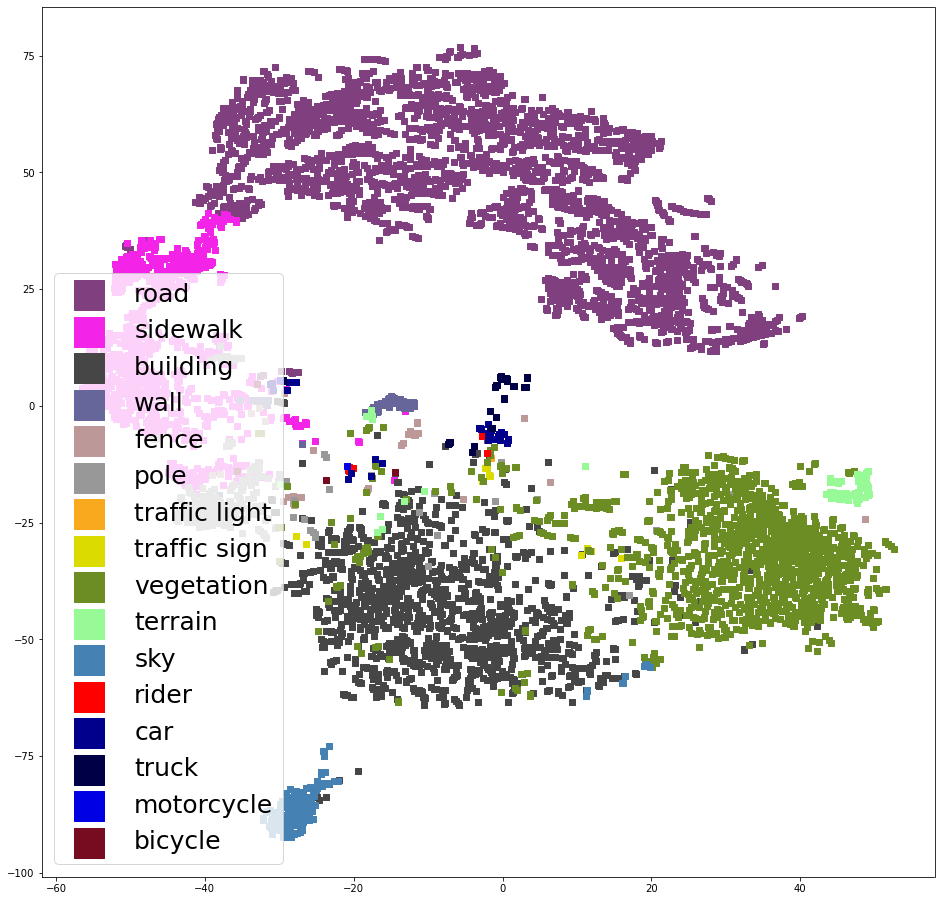

In [26]:
samples_s1, plot_labels, filename_s1 = preprocess_fn_enco(output_enc_s1, targets_s1, model_name='p100-KLD-rapft', step=1)

tsne_s1 = TSNE(n_components=2, perplexity=100.0, n_iter=2000, random_state=2).fit_transform(samples_s1)
print(tsne_s1.shape)

plot_tsne(tsne_s1, plot_labels, filename_s1, cmap_cs)

torch.Size([8192, 128])
torch.Size([1, 1, 64, 128])
15
torch.Size([8192])
./tsne_plots/encoCS_p100-KLD-rapft_step2_frankfurt_000000_017476.png
torch.Size([8192, 128])
(8192,)
(8192, 128)
(8192,)
[ 0  1  2  5  6  7  8 10 11 12 13 15 17 18 19] 15
(8192, 2)


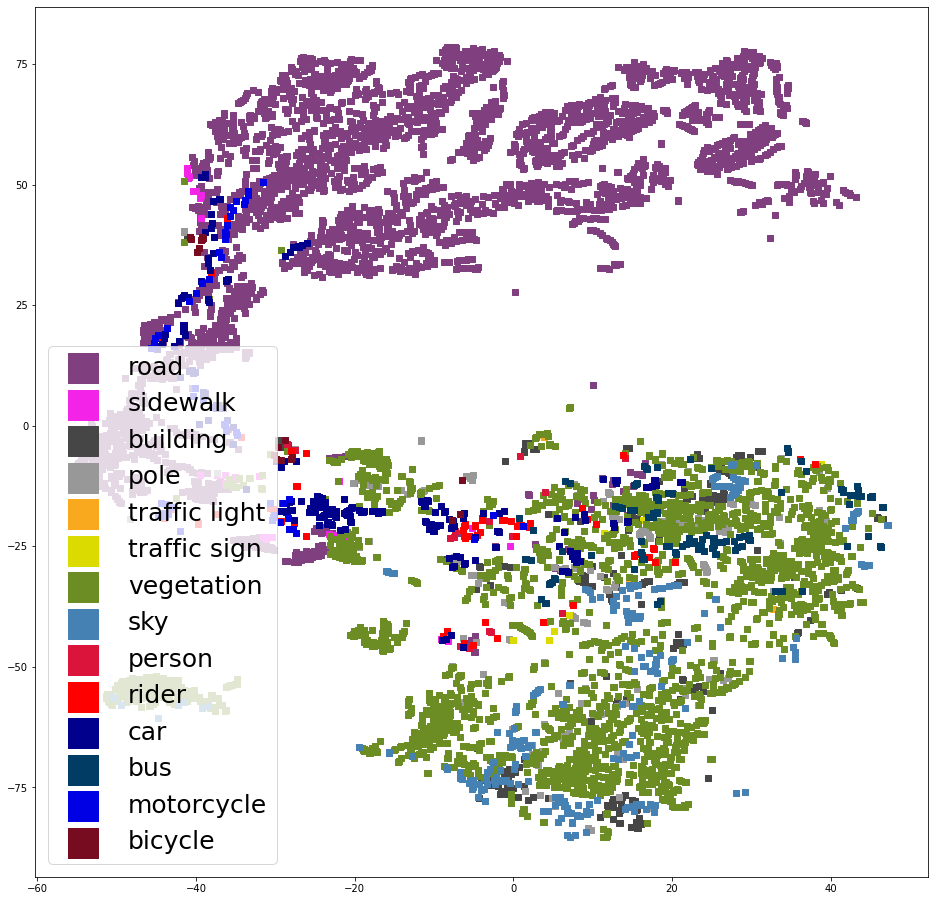

In [25]:
samples_klds2, plot_labels, filename_klds2 = preprocess_fn_enco(output_enc, targets, model_name='p100-KLD-rapft', step=2)

tsne_klds2 = TSNE(n_components=2, perplexity=100.0, n_iter=2000, random_state=2).fit_transform(samples_klds2)
print(tsne_klds2.shape)
plot_tsne(tsne_klds2, plot_labels, filename_klds2, cmap_cs)

In [24]:
# Fine-tuning, STEP 2
model_step2 = Net_ft1_LS(num_classes_old=20, num_classes_new=20) # step 2 - CS
model_step2 = torch.nn.DataParallel(model_step2).cuda()
saved_model = torch.load('/home2/prachigarg/temp_MDILSS/checkpoints/FineTune/checkpoint_erfnet_ftp1_150_6_Finetune-CStoBDD-final.pth.tar')
model_step2.load_state_dict(saved_model['state_dict'])

output_ft1, output_enc_ft1, targets, filename = eval_visualize_finetune(model_step2, loader_val_CS, criterion_CS, 0, [20, 20])
print(output_ft1.size(), output_enc_ft1.size(), targets.size(), filename)

tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 17, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  4,  5,  6,  7,  8, 10, 11, 13, 15, 17, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 15, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 17, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 13, 17, 18, 19],
       device='cuda:0')
tensor([ 0,  1,  2,  5,  6,  7,  8, 10, 11, 12, 13, 15, 17, 18, 19],
 

torch.Size([8192, 128])
torch.Size([1, 1, 64, 128])
15
torch.Size([8192])
./tsne_plots/encoCS_p100-ft1_step1_frankfurt_000000_017476.png
torch.Size([8192, 128])
(8192,)
(8192, 128)
(8192,)
[ 0  1  2  5  6  7  8 10 11 12 13 15 17 18 19] 15
(8192, 2)


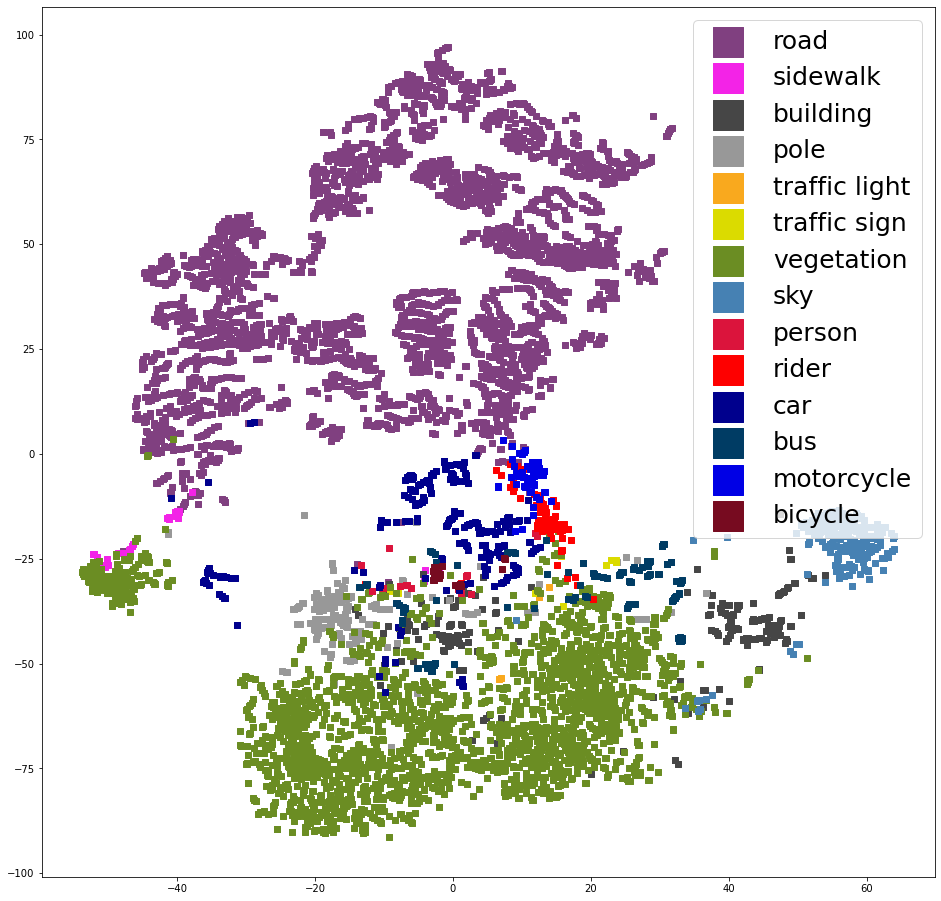

In [27]:
samples_ft1, plot_labels, filename_ft1 = preprocess_fn_enco(output_enc_ft1, targets, model_name='p100-ft1', step=1)

tsne_ft1 = TSNE(n_components=2, perplexity=100.0, n_iter=2000, random_state=2).fit_transform(samples_ft1)
print(tsne_ft1.shape)

plot_tsne(tsne_ft1, plot_labels, filename_ft1, cmap_cs)